In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
import time
%config InlineBackend.figure_formats = ['svg']
plt.style.use('fivethirtyeight')
import pytorch_lightning as pl
from pytorch_lightning.callbacks import TQDMProgressBar, LearningRateMonitor
import warnings
warnings.filterwarnings("ignore")
import torchmetrics

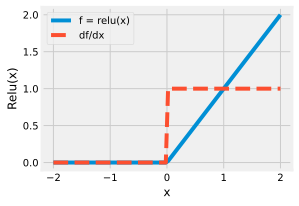

In [37]:
plt.figure(figsize=(4,3))
x = torch.linspace(-2.0, 2.0, 100, requires_grad=True)
y = torch.relu(x)
y.backward(torch.ones_like(x))

plt.plot(x.detach(), y.detach(), label='f = relu(x)');
plt.plot(x.detach(), x.grad.detach(), 'C1--', label='df/dx');
plt.xlabel('x')
plt.ylabel('Relu(x)')
plt.legend();

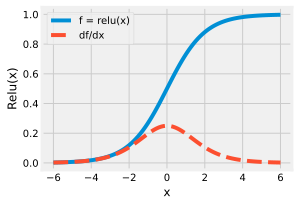

In [46]:
plt.figure(figsize=(4,3))
x = torch.linspace(-6.0, 6.0, 100, requires_grad=True)
y = torch.sigmoid(x)
y.backward(torch.ones_like(x))

plt.plot(x.detach(), y.detach(), label='f = relu(x)');
plt.plot(x.detach(), x.grad.detach(), 'C1--', label='df/dx');
plt.xlabel('x')
plt.ylabel('Relu(x)')
plt.legend();


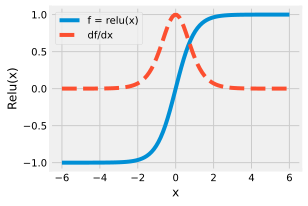

In [47]:
plt.figure(figsize=(4,3))
x = torch.linspace(-6.0, 6.0, 100, requires_grad=True)
y = torch.tanh(x)
y.backward(torch.ones_like(x))

plt.plot(x.detach(), y.detach(), label='f = relu(x)');
plt.plot(x.detach(), x.grad.detach(), 'C1--', label='df/dx');
plt.xlabel('x')
plt.ylabel('Relu(x)')
plt.legend();


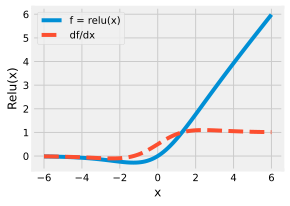

In [53]:
plt.figure(figsize=(4,3))
x = torch.linspace(-6.0, 6.0, 100, requires_grad=True)
y = torch.nn.functional.silu(x)
y.backward(torch.ones_like(x))

plt.plot(x.detach(), y.detach(), label='f = relu(x)');
plt.plot(x.detach(), x.grad.detach(), 'C1--', label='df/dx');
plt.xlabel('x')
plt.ylabel('Relu(x)')
plt.legend();

In [54]:
# Import Datasets
class FashionMNIST:
    def __init__(self) -> None:
        # Get datasets
        self.train = datasets.FashionMNIST(root='data', train=True, transform=ToTensor())
        self.val = datasets.FashionMNIST(root='data', train=False, transform=ToTensor())

        # Create data loaders
        self.train_dl = torch.utils.data.DataLoader(self.train, batch_size = 1024, shuffle=True)
        self.val_dl = torch.utils.data.DataLoader(self.val, batch_size = 1024, shuffle=True)

data = FashionMNIST()
len(data.train), len(data.val), len(data.train_dl), len(data.val_dl)

(60000, 10000, 59, 10)

In [59]:
class Classifier(nn.Module):
    def __init__(self, in_features, out_features, num_hidden):
        super().__init__()
        self.W1 = nn.Parameter(torch.randn(in_features, num_hidden)/in_features**0.5)
        self.b1 = nn.Parameter(torch.randn(num_hidden)/in_features**0.5)
        self.W2 = nn.Parameter(torch.randn(num_hidden, out_features)/num_hidden**0.5)
        self.b2 = nn.Parameter(torch.randn(out_features)/num_hidden**0.5)

    def relu(x):
        return torch.max(0, x)

    def forward(self, x):
        h = self.relu(x @ self.W1 + self.b1)
        return h @ self.W2 + self.b2

In [60]:
model = Classifier(784, 10, 128)

In [66]:
for p in model.parameters():
    print(p.shape)

torch.Size([784, 128])
torch.Size([128])
torch.Size([128, 10])
torch.Size([10])
